# 1. Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# EDA Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from pathlib import Path
import random

# Scikit-Learn models
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from xgboost.sklearn import XGBRegressor

# LSTM
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# ARIMA Model
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

# PMDARIMA Model
!pip install pmdarima
import pmdarima as pm

# 2. Loading and Exploration of the Data

   Customer Reference ID Item Purchased  Purchase Amount (USD) Date Purchase  \
0                   4018        Handbag                 4619.0    2023-02-05   
1                   4115          Tunic                 2456.0    2023-07-11   
2                   4019       Tank Top                 2102.0    2023-03-23   
3                   4097       Leggings                 3126.0    2023-03-15   
4                   3997         Wallet                 3003.0    2022-11-27   

   Review Rating Payment Method  Sales per Item  Store ID  
0            NaN    Credit Card             NaN       NaN  
1            2.0    Credit Card             NaN       NaN  
2            4.1           Cash             NaN       NaN  
3            3.2           Cash             NaN       NaN  
4            4.7           Cash             NaN       NaN  
count    67750.000000
mean      3041.315141
std       2107.396971
min          7.890000
25%       1305.980000
50%       2831.320000
75%       4451.422500
max  

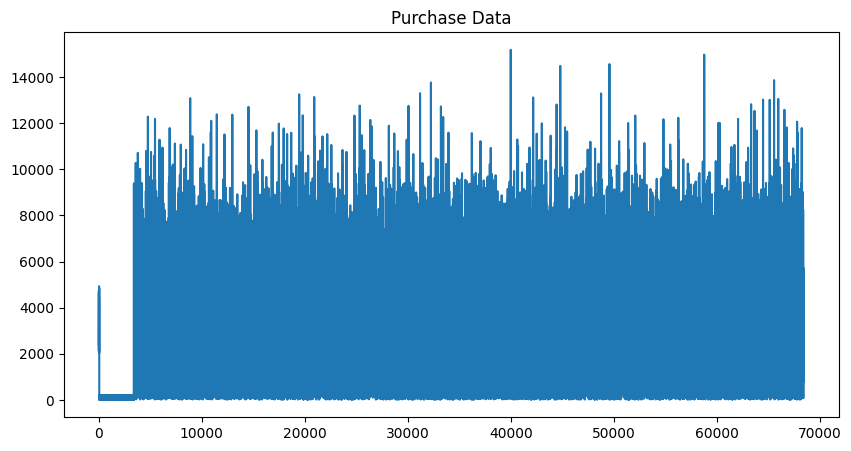

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Function to load data
def load_data(file_name):
    """Returns a pandas dataframe from a csv file."""
    return pd.read_csv(file_name)

# Load the dataset
dataset_path = '/content/Extended_Fashion_Retail_Sales.csv'
df = load_data(dataset_path)
print(df.head())

# Basic statistical details about the purchase amount
print(df['Purchase Amount (USD)'].describe())

# Plotting purchase data
plt.figure(figsize=(10, 5))
df['Purchase Amount (USD)'].plot(title='Purchase Data')
plt.show()

In [ ]:
# Check for missing values and duplicate rows in the extended dataset

# Assuming 'df' contains your extended fashion sales data:
extended_fashion_sales_data = df  # Assign 'df' to 'extended_fashion_sales_data'

# Checking for missing values
missing_values = extended_fashion_sales_data.isnull().sum()

# Checking for duplicate rows
duplicate_rows = extended_fashion_sales_data.duplicated().sum()

#missing_values, duplicate_rows
print (missing_values)
print (duplicate_rows)

Customer Reference ID       0
Item Purchased              0
Purchase Amount (USD)     650
Date Purchase               0
Review Rating             324
Payment Method              0
Sales per Item           3400
Store ID                 3400
dtype: int64
0


In [ ]:
# Drop rows with any missing values
#df_cleaned = df.dropna()

# Verify that there are no missing values left
#missing_values_after = df_cleaned.isnull().sum()
#print("Missing values after dropping rows:")
#print(missing_values_after)

In [ ]:
# Handle missing values in numerical columns using mean/median
extended_fashion_sales_data['Purchase Amount (USD)'].fillna(
    extended_fashion_sales_data['Purchase Amount (USD)'].mean(), inplace=True)  # or median()

extended_fashion_sales_data['Sales per Item'].fillna(
    extended_fashion_sales_data['Sales per Item'].mean(), inplace=True)  # or median()

# Handle missing values in categorical columns using mode
extended_fashion_sales_data['Item Purchased'].fillna(
    extended_fashion_sales_data['Item Purchased'].mode()[0], inplace=True)

extended_fashion_sales_data['Payment Method'].fillna(
    extended_fashion_sales_data['Payment Method'].mode()[0], inplace=True)

extended_fashion_sales_data['Store ID'].fillna(
    extended_fashion_sales_data['Store ID'].mode()[0], inplace=True)

extended_fashion_sales_data['Review Rating'].fillna(
    extended_fashion_sales_data['Review Rating'].median(), inplace=True)  # Using median for ratings

# Verify that there are no missing values left
missing_values_after = extended_fashion_sales_data.isnull().sum()
print(missing_values_after)

Customer Reference ID    0
Item Purchased           0
Purchase Amount (USD)    0
Date Purchase            0
Review Rating            0
Payment Method           0
Sales per Item           0
Store ID                 0
dtype: int64


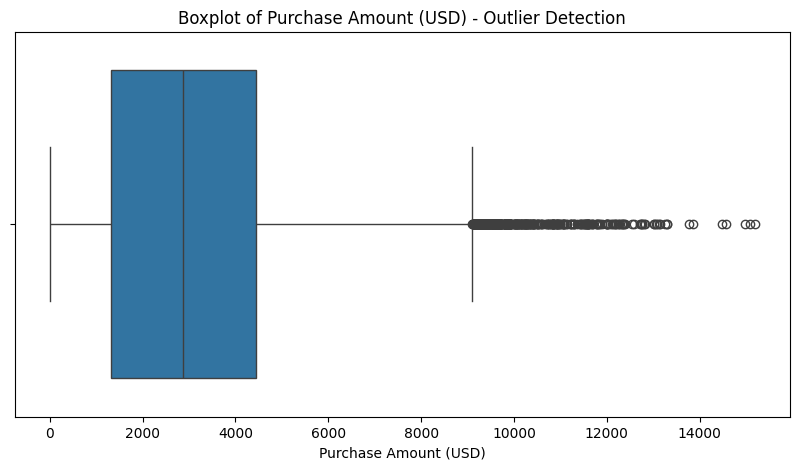

Number of outliers: 426
      Date Purchase  Purchase Amount (USD)
3407     2019-04-14                9390.17
3582     2019-06-16               10277.94
3663     2019-04-14                9267.06
3680     2019-04-06               10077.41
3773     2019-07-11               10280.75
...             ...                    ...
67791    2023-03-12               12064.29
67858    2023-01-26               11590.25
68082    2023-02-27                9154.07
68173    2023-04-02                9379.07
68239    2023-03-21               11788.62

[426 rows x 2 columns]


In [ ]:
# Visualize the distribution with a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Purchase Amount (USD)', data=extended_fashion_sales_data)
plt.title("Boxplot of Purchase Amount (USD) - Outlier Detection")
plt.show()

# Calculate IQR for the 'Purchase Amount (USD)' column
Q1 = extended_fashion_sales_data['Purchase Amount (USD)'].quantile(0.25)
Q3 = extended_fashion_sales_data['Purchase Amount (USD)'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = extended_fashion_sales_data[
    (extended_fashion_sales_data['Purchase Amount (USD)'] < lower_bound) |
    (extended_fashion_sales_data['Purchase Amount (USD)'] > upper_bound)
]

print(f"Number of outliers: {len(outliers)}")
print(outliers[['Date Purchase', 'Purchase Amount (USD)']])

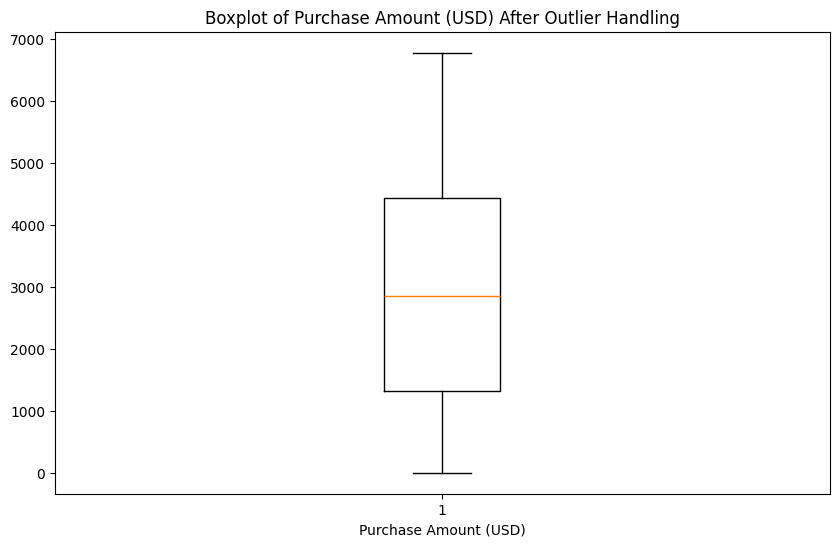

count    68400.000000
mean      2984.855667
std       1961.690594
min          7.890000
25%       1319.352500
50%       2861.245000
75%       4433.932500
max       6779.420500
Name: Purchase Amount (USD), dtype: float64


In [ ]:
# Define the capping threshold at the 95th percentile
cap_value = extended_fashion_sales_data['Purchase Amount (USD)'].quantile(0.95)

# Cap the outliers
extended_fashion_sales_data['Purchase Amount (USD)'] = np.where(
    extended_fashion_sales_data['Purchase Amount (USD)'] > cap_value,
    cap_value,
    extended_fashion_sales_data['Purchase Amount (USD)']
)

# Re-plot the boxplot to check for outliers after capping
plt.figure(figsize=(10, 6))
plt.boxplot(extended_fashion_sales_data['Purchase Amount (USD)'])
plt.title("Boxplot of Purchase Amount (USD) After Outlier Handling")
plt.xlabel("Purchase Amount (USD)")
plt.show()

# Display summary statistics for Purchase Amount (USD) after handling outliers
print(extended_fashion_sales_data['Purchase Amount (USD)'].describe())

## Function to Aggregate Sales Data Monthly or Yearly

In [ ]:
# Mount Google Drive if you want to save the file there
# drive.mount('/content/drive')

def monthly_or_years_sales(data, time='monthly'):
    """Aggregate sales data either monthly or yearly."""
    datadata = data.copy()

    if time == "monthly":
        # Extract year and month from the 'Date Purchase' column
        datadata['Date Purchase'] = datadata['Date Purchase'].apply(lambda x: str(x)[:7])
    else:
        # Extract only the year from the 'Date Purchase' column
        datadata['Date Purchase'] = datadata['Date Purchase'].apply(lambda x: str(x)[:4])

    # Sum purchase amounts per specified time period (month or year)
    datadata = datadata.groupby('Date Purchase')['Purchase Amount (USD)'].sum().reset_index()
    datadata['Date Purchase'] = pd.to_datetime(datadata['Date Purchase'])

    return datadata

# Assuming df is the loaded dataset
m_df = monthly_or_years_sales(df, "monthly")

# To save to Colab's root directory
m_df.to_csv('monthly_data.csv', index=False)
print(m_df.head(10))

# To save in Google Drive, uncomment below:
# m_df.to_csv('/content/drive/My Drive/monthly_data.csv', index=False)

# Aggregating data yearly
y_df = monthly_or_years_sales(df, "years")
print(y_df.head())

  Date Purchase  Purchase Amount (USD)
0    2019-01-01           3.896663e+06
1    2019-02-01           3.357494e+06
2    2019-03-01           3.857481e+06
3    2019-04-01           3.891537e+06
4    2019-05-01           3.969816e+06
5    2019-06-01           3.441380e+06
6    2019-07-01           3.242021e+06
7    2019-08-01           3.015495e+06
8    2019-09-01           2.669463e+06
9    2019-10-01           2.687597e+06
  Date Purchase  Purchase Amount (USD)
0    2019-01-01           4.049984e+07
1    2020-01-01           4.045118e+07
2    2021-01-01           4.049880e+07
3    2022-01-01           4.054784e+07
4    2023-01-01           4.216647e+07


## Plotting Monthly and Yearly Sales

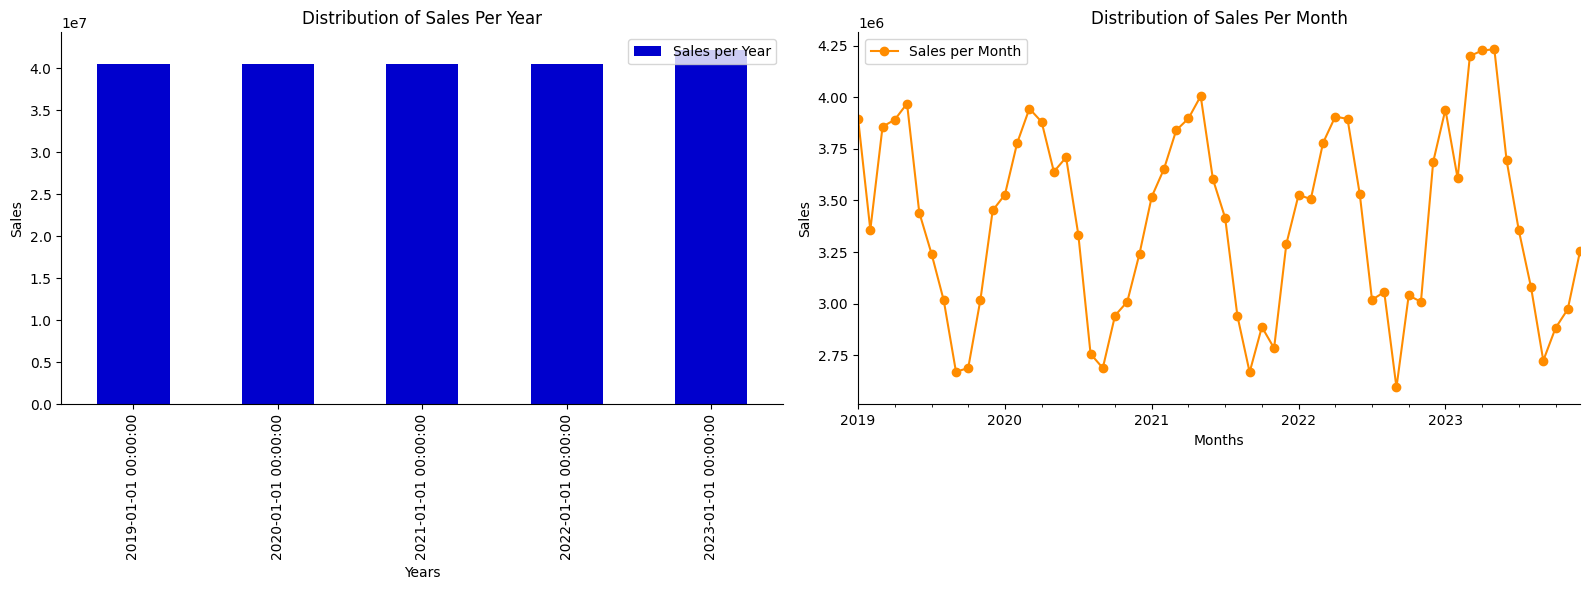

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting yearly sales
y_df.plot(kind="bar", x='Date Purchase', y='Purchase Amount (USD)', color='mediumblue', label="Sales per Year", ax=ax1)
ax1.set_title("Distribution of Sales Per Year")
ax1.set_xlabel("Years")
ax1.set_ylabel("Sales")
ax1.legend()

# Plotting monthly sales
m_df.plot(kind='line', x='Date Purchase', y='Purchase Amount (USD)', marker='o', color='darkorange', label="Sales per Month", ax=ax2)
ax2.set_title("Distribution of Sales Per Month")
ax2.set_xlabel("Months")
ax2.set_ylabel("Sales")
ax2.legend()

sns.despine()
plt.tight_layout()
plt.show()

# EDA(Exploratory Data Analysis)

In [ ]:
# Calculate monthly differences in sales
m_df['Sales Difference'] = m_df['Purchase Amount (USD)'].diff()

## Time Interval of the Dataset

In [ ]:
# Convert 'Date Purchase' to datetime format
df['Date Purchase'] = pd.to_datetime(df['Date Purchase'])

In [ ]:
# Function to calculate the sales time interval
def sales_time(data):
    """Time interval of dataset:"""
    n_of_days = data['Date Purchase'].max() - data['Date Purchase'].min()
    n_of_years = int(n_of_days.days / 365)

    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonths: {12 * n_of_years}")

sales_time(df)

Days: 1825
Years: 5
Months: 60


## Overall and Recent Average Monthly Sales

In [ ]:
# Overall average monthly sales
average_m_sales = m_df['Purchase Amount (USD)'].mean()
print(f"Overall Average Monthly Sales: ${average_m_sales:.2f}")

def average_12months(data):
    """Prints the average monthly sales for the last 12 months."""
    average_m_sales_1y = data['Purchase Amount (USD)'].tail(12).mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y:.2f}")

average_12months(m_df)

Overall Average Monthly Sales: $3402735.46
Last 12 months average monthly sales: $3513872.26


## Sales Per Store

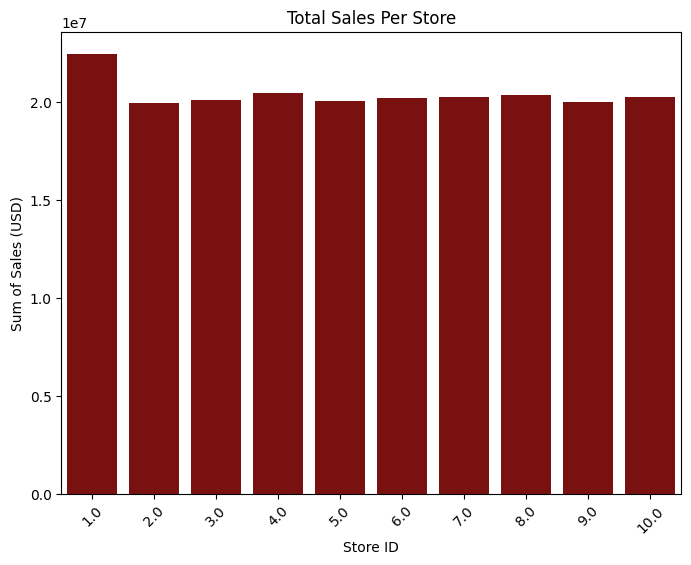

,Store ID,Purchase Amount (USD)
0,1.0,2.245476e+07
1,2.0,1.995473e+07
2,3.0,2.010869e+07
3,4.0,2.044862e+07
4,5.0,2.005510e+07
5,6.0,2.020787e+07
6,7.0,2.028826e+07
7,8.0,2.034322e+07
8,9.0,2.003271e+07
9,10.0,2.027017e+07


In [ ]:
# Function to calculate sales per store
def sales_per_store(data):
    sales_by_store = data.groupby('Store ID')['Purchase Amount (USD)'].sum().reset_index()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=sales_by_store['Store ID'], y=sales_by_store['Purchase Amount (USD)'], color='darkred', ax=ax)

    ax.set(xlabel="Store ID", ylabel="Sum of Sales (USD)", title="Total Sales Per Store")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

    return sales_by_store

# Call the sales_per_store function
sales_per_store(df)

## Average Monthly Sales Calculation

In [ ]:
# Overall average monthly sales
average_m_sales = m_df['Purchase Amount (USD)'].mean()
print(f"Overall Average Monthly Sales: ${average_m_sales:.2f}")

# Function to calculate the average sales for the last 12 months
def average_12months(data):
    average_m_sales_1y = m_df['Purchase Amount (USD)'][-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y:.2f}")

# Call the average_12months function
average_12months(m_df)

Overall Average Monthly Sales: $3402735.46
Last 12 months average monthly sales: $3513872.26


## Time Series Stationarity Plot

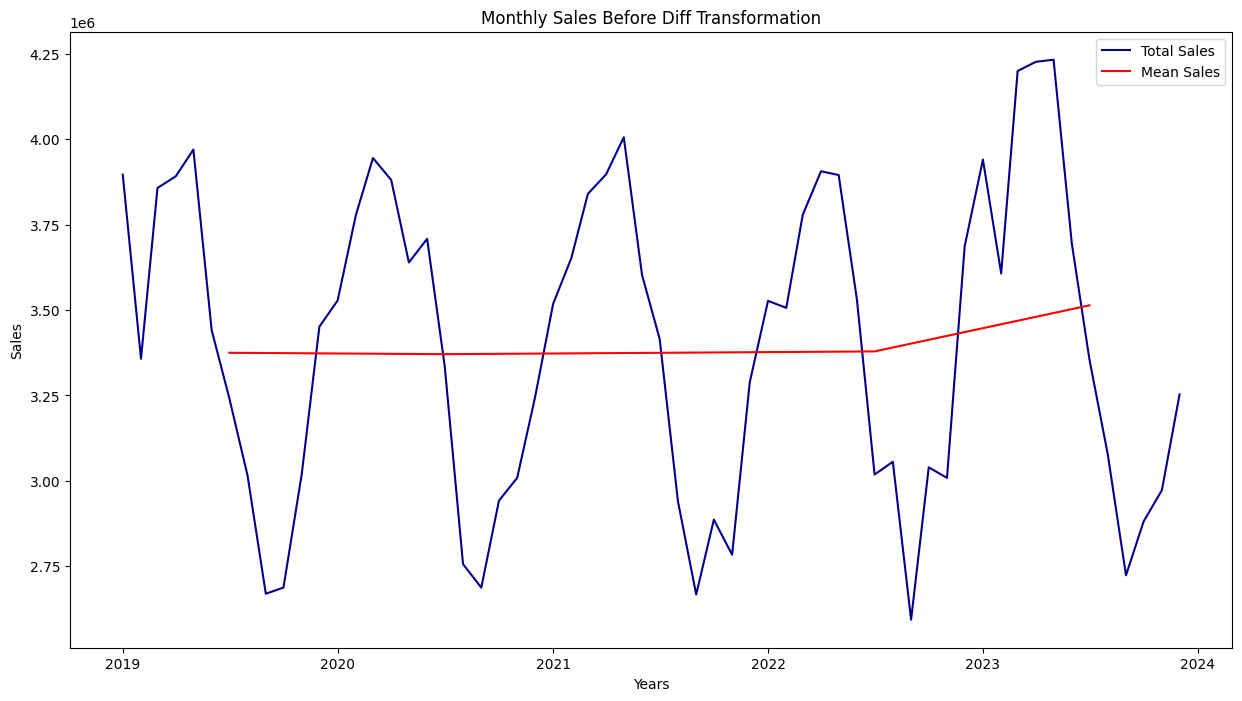

In [ ]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color='darkblue', label='Total Sales')

    # Calculate the mean sales for each year
    s_mean = data.groupby(data['Date Purchase'].dt.year)[y_col].mean().reset_index()
    s_mean['Date Purchase'] = pd.to_datetime(s_mean['Date Purchase'], format='%Y')

    # Shift the mean sales plot for better visualization
    sns.lineplot(x=(s_mean['Date Purchase'] + pd.DateOffset(months=6)), y=y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')

    ax.set(xlabel="Years",
           ylabel="Sales",
           title=title)
    plt.legend()
    plt.show()

# Calling the function to plot monthly sales
time_plot(m_df, 'Date Purchase', 'Purchase Amount (USD)', 'Monthly Sales Before Diff Transformation')

## Differencing for Stationarity

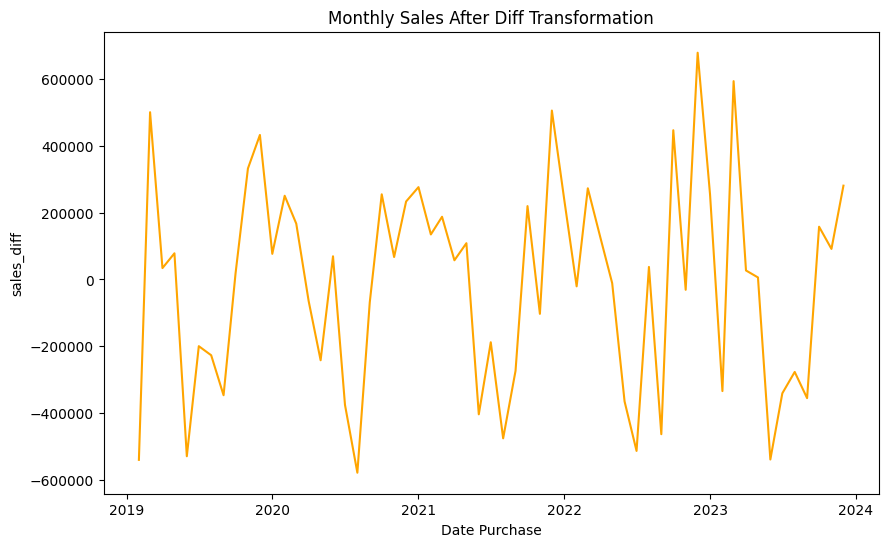

In [ ]:
# Mount Google Drive if you want to save the file there
# drive.mount('/content/drive')

def get_diff(data):
    """Calculate the difference in sales month over month."""

    # Calculate the difference in 'Purchase Amount (USD)'
    data['sales_diff'] = data['Purchase Amount (USD)'].diff()
    data_diff = data.dropna()  # Drop any rows with NaN values resulting from differencing

    # Save the stationary DataFrame to a CSV in Colab’s root directory
    data_diff.to_csv('stationary_df.csv', index=False)

    # Uncomment the line below to save it to Google Drive
    # data_diff.to_csv('/content/drive/My Drive/stationary_df.csv', index=False)

    return data_diff

# Get the stationary DataFrame
stationary_df = get_diff(m_df)

# Function to plot the differenced sales data
def time_plot(data, x_col, y_col, title):
    """Plot time series data."""
    plt.figure(figsize=(10, 6))
    plt.plot(data[x_col], data[y_col], color='orange')
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Plot the differenced sales data
time_plot(stationary_df, 'Date Purchase', 'sales_diff', 'Monthly Sales After Diff Transformation')

# ARIMA Modeling

In [ ]:
# Mount Google Drive if you want to save the file there
# drive.mount('/content/drive')

def build_arima_data(data):
    """Generates a CSV file with a datetime index and a dependent sales column for ARIMA modeling."""

    # Set 'Date Purchase' as the index and drop 'sales_diff' column
    da_data = data.set_index('Date Purchase').drop('sales_diff', axis=1)  # Use 'sales_diff' after differencing

    da_data.dropna(axis=0, inplace=True)  # Drop any rows with NaN values

    # Save the ARIMA DataFrame to a CSV in Colab’s root directory
    da_data.to_csv('arima_df.csv')

    # Uncomment the line below to save it to Google Drive
    # da_data.to_csv('/content/drive/My Drive/arima_df.csv')

    return da_data

# Generate the ARIMA DataFrame
arima_df = build_arima_data(stationary_df)
print(arima_df.head())  # Display the ARIMA DataFrame

               Purchase Amount (USD)  Sales Difference
Date Purchase                                         
2019-02-01              3.357494e+06      -539168.8690
2019-03-01              3.857481e+06       499986.5125
2019-04-01              3.891537e+06        34056.1945
2019-05-01              3.969816e+06        78279.1060
2019-06-01              3.441380e+06      -528436.5340


# Observing Lags

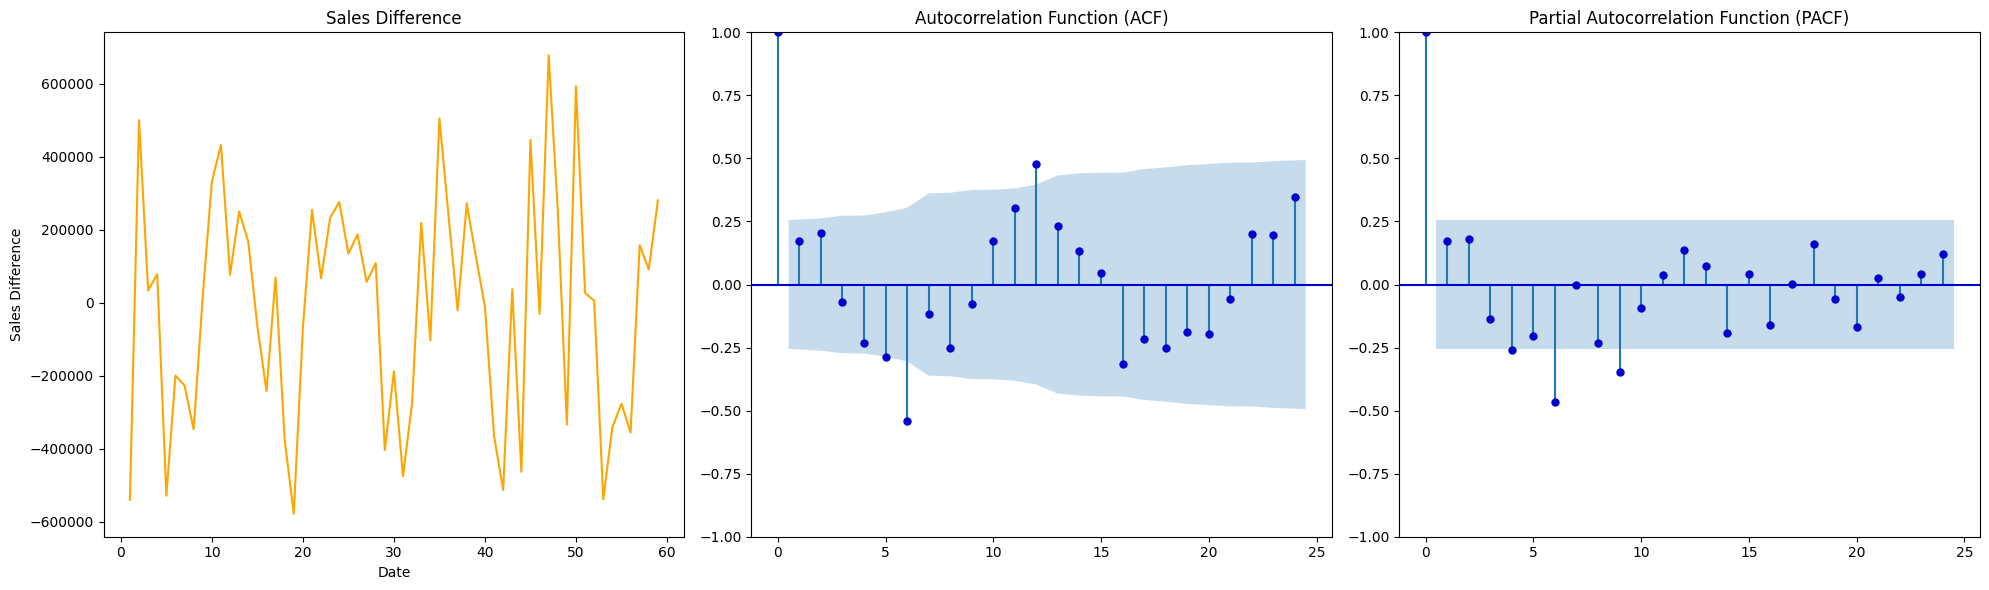

In [ ]:
import statsmodels.api as smt  # Ensure statsmodels is imported

def plots_lag(data, lags=None):
    """Convert dataframe to datetime index and plot sales difference, ACF, and PACF."""
    # Set 'Date Purchase' as the index and drop the 'sales_diff' column
    dt_data = data.set_index('Date Purchase').drop('sales_diff', axis=1)
    dt_data.dropna(axis=0, inplace=True)

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # One row, three columns

    # Extract the sales_diff as a Series for plotting
    sales_diff = data['sales_diff'].dropna()

    # Plot the sales difference
    sales_diff.plot(ax=axs[0], color='orange')
    axs[0].set_title('Sales Difference')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Sales Difference')

    # Plot the autocorrelation function (ACF)
    smt.graphics.tsa.plot_acf(sales_diff, lags=lags, ax=axs[1], color='mediumblue')
    axs[1].set_title('Autocorrelation Function (ACF)')

    # Plot the partial autocorrelation function (PACF)
    smt.graphics.tsa.plot_pacf(sales_diff, lags=lags, ax=axs[2], color='mediumblue')
    axs[2].set_title('Partial Autocorrelation Function (PACF)')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

# Call the function to plot sales difference, ACF, and PACF for 24 lags
plots_lag(stationary_df, lags=24)

## Model Score

In [ ]:
# Dictionary to store model scores
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""

    # Extract the actual sales values and predicted values for the last 12 months
    actual_sales = origin_df['Purchase Amount (USD)'][-12:]  # Use the actual sales column
    predicted_sales = unscale_df['pred_value'][-12:]  # Use the predicted values from the DataFrame

    # Calculate RMSE, MAE, and R2
    rmse = np.sqrt(mean_squared_error(actual_sales, predicted_sales))
    mae = mean_absolute_error(actual_sales, predicted_sales)
    r2 = r2_score(actual_sales, predicted_sales)

    # Store the scores in the model_scores dictionary
    model_scores[model_name] = [rmse, mae, r2]

    # Print the scores
    print(f"{model_name} Performance:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2 Score: {r2:.2f}\n")

# Example of how to call the function
# get_scores(predicted_sales_df, original_sales_df, "Linear Regression")

# Modelling

## 1. SARIMAX

In [ ]:
# Example of creating datatime_df from your original DataFrame (m_df)
datatime_df = m_df.copy()  # or however you previously structured it

# Ensure the date column is set as the index and is in datetime format
datatime_df['Date Purchase'] = pd.to_datetime(datatime_df['Date Purchase'])  # Ensure datetime
datatime_df.set_index('Date Purchase', inplace=True)  # Set the date column as index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


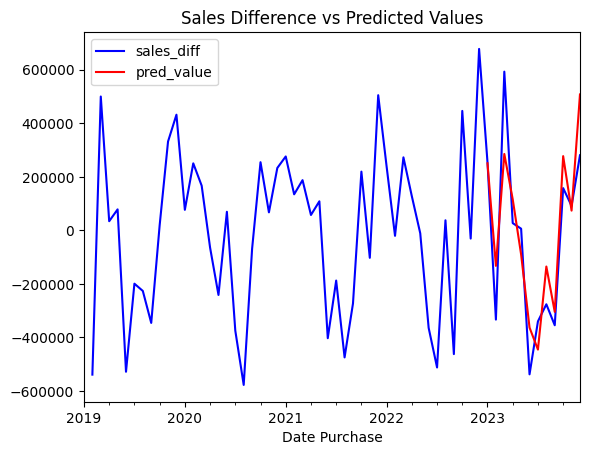

ARIMA Model Performance:
RMSE: 153434.80
MAE: 127793.32
R2 Score: 0.77


In [ ]:
def sarimax_model(data):
    """Fits a SARIMAX model to the data and generates predictions."""

    # Fit the SARIMAX model
    sar = sm.tsa.statespace.SARIMAX(data['sales_diff'], order=(12, 0, 0),
                                      seasonal_order=(0, 1, 0, 12),
                                      trend='c').fit()

    # Generate predictions
    start = len(data) - 12  # Start predicting after the training set
    end = len(data) - 1      # End with the last observation
    dynamic = True  # Set to True if you want dynamic predictions

    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)

    # Plot the actual vs predicted values
    data[['sales_diff', 'pred_value']].plot(color=['blue', 'red'])
    plt.title('Sales Difference vs Predicted Values')
    plt.legend(loc='upper left')
    plt.show()

    # Calculate model performance metrics
    rmse = np.sqrt(mean_squared_error(data['sales_diff'][-12:], data['pred_value'][-12:]))
    mae = mean_absolute_error(data['sales_diff'][-12:], data['pred_value'][-12:])
    r2 = r2_score(data['sales_diff'][-12:], data['pred_value'][-12:])

    model_scores['ARIMA'] = [rmse, mae, r2]

    print(f"ARIMA Model Performance:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2 Score: {r2:.2f}")

    return sar, data, data['pred_value']

# Ensure the index is datetime
datatime_df.index = pd.to_datetime(datatime_df.index)

# Fit the model
sar, datatime_df, predictions = sarimax_model(datatime_df)

# 2. AutoARIMA

In [ ]:
# Check for missing values in sales_diff
print("Missing values in sales_diff:", datatime_df['sales_diff'].isnull().sum())

# Option 1: Drop missing values
datatime_df = datatime_df.dropna(subset=['sales_diff'])

# Option 2: Impute missing values (choose one method that suits your data)
# datatime_df['sales_diff'] = datatime_df['sales_diff'].interpolate()  # Interpolation
# datatime_df['sales_diff'] = datatime_df['sales_diff'].fillna(method='ffill')  # Forward fill
# datatime_df['sales_diff'] = datatime_df['sales_diff'].fillna(datatime_df['sales_diff'].mean())  # Fill with mean

Missing values in sales_diff: 1


Fitting the AutoARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1312.402, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1295.341, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1295.129, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1311.716, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1313.934, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1296.812, Time=0.25 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1297.111, Time=0.34 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1296.935, Time=0.10 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1298.783, Time=0.26 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1296.042, Time=1.52 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1295.823, Time=0.65 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1293.247, Time=0.54 se

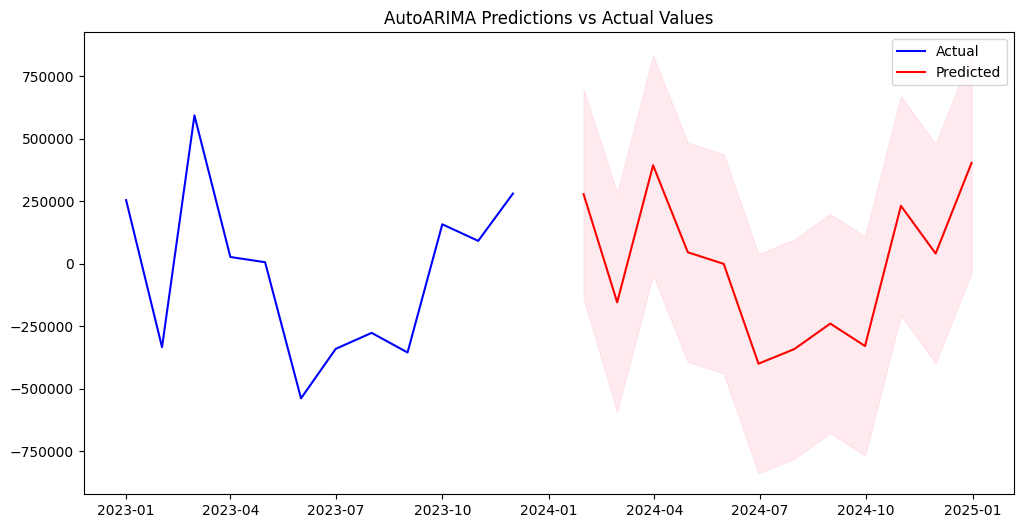

Model Performance:
RMSE: 98825.34
MAE: 73121.77
R² Score: 0.90


In [ ]:
import joblib  # Import joblib for saving and loading models

def autoarima_model(data, save_model=True):
    """Fits an AutoARIMA model to the data and generates predictions."""

    print("Fitting the AutoARIMA model...")

    # Fit the AutoARIMA model
    model = pm.auto_arima(data['sales_diff'], seasonal=True, m=12,
                          stepwise=True, trace=True)

    print("Model fitted successfully.")

    # Save the model to disk
    if save_model:
        model_file = 'autoarima_model.pkl'
        joblib.dump(model, model_file)
        print(f"Model saved successfully to {model_file}")

    # Generate predictions
    n_periods = 12  # Number of periods to predict
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-12:], data['sales_diff'][-12:], label='Actual', color='blue')
    forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='M')
    plt.plot(forecast_index, forecast, label='Predicted', color='red')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
    plt.title('AutoARIMA Predictions vs Actual Values')
    plt.legend()
    plt.show()

    # Calculate performance metrics
    actual_sales = data['sales_diff'][-12:].values
    rmse = np.sqrt(mean_squared_error(actual_sales, forecast))
    mae = mean_absolute_error(actual_sales, forecast)
    r2 = r2_score(actual_sales, forecast)

    print(f"Model Performance:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR² Score: {r2:.2f}")

# Ensure you have data loaded and preprocessed as needed
# Call the model fitting and saving function
autoarima_model(datatime_df)